In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# Mengatur device, akan menggunakan GPU jika tersedia di Kaggle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

Menggunakan device: cuda


In [16]:
# Encoder dengan 3 lapis konvolusi
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            # Input: [batch_size, 1, 32, 32]
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: [16, 16, 16]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: [32, 8, 8]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # Output: [64, 4, 4]
            nn.ReLU(),
            nn.Flatten(),                                        # Flatten menjadi: 64 * 4 * 4 = 1024
            nn.Linear(64 * 4 * 4, 2)                             # --- PERBAIKAN DI SINI ---
        )

    def forward(self, x):
        return self.encoder(x)

# Decoder dengan 3 lapis dekonvolusi
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(2, 64 * 4 * 4),                            # --- PERBAIKAN DI SINI ---
            nn.Unflatten(1, (64, 4, 4)),                         # --- PERBAIKAN DI SINI ---
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [32, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: [16, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: [1, 32, 32]
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

# Menggabungkan Encoder dan Decoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [17]:
# Kelas untuk memuat Fashion MNIST dari file CSV
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx].values
        label = int(row[0])
        image = row[1:].astype(np.uint8).reshape(28, 28)
        image = self.transform(image)
        return image, label

# Path dataset di Kaggle (yang sudah diperbaiki sesuai direktori Anda)
train_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_train.csv'
test_csv_path = '/kaggle/input/fashionmnist/fashion-mnist_test.csv'

# Membuat dataset dan DataLoader
train_dataset = FashionMNISTDataset(train_csv_path)
test_dataset = FashionMNISTDataset(test_csv_path)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Dataset dan DataLoader siap.")

Dataset dan DataLoader siap.


In [18]:
# Inisialisasi model, loss, dan optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

# Loop pelatihan
train_loss = []
for epoch in range(epochs):
    total_loss = 0
    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs = imgs.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Simpan model yang sudah dilatih
torch.save(model.state_dict(), 'autoencoder_fashion_mnist.pth')
print("\n✅ Model berhasil dilatih dan disimpan.")

Epoch 1/20: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]


Epoch [1/20], Loss: 0.0471


Epoch 2/20: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]


Epoch [2/20], Loss: 0.0286


Epoch 3/20: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]


Epoch [3/20], Loss: 0.0268


Epoch 4/20: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]


Epoch [4/20], Loss: 0.0257


Epoch 5/20: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]


Epoch [5/20], Loss: 0.0251


Epoch 6/20: 100%|██████████| 469/469 [00:13<00:00, 35.60it/s]


Epoch [6/20], Loss: 0.0246


Epoch 7/20: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]


Epoch [7/20], Loss: 0.0242


Epoch 8/20: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]


Epoch [8/20], Loss: 0.0239


Epoch 9/20: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]


Epoch [9/20], Loss: 0.0236


Epoch 10/20: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]


Epoch [10/20], Loss: 0.0234


Epoch 11/20: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]


Epoch [11/20], Loss: 0.0232


Epoch 12/20: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]


Epoch [12/20], Loss: 0.0230


Epoch 13/20: 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]


Epoch [13/20], Loss: 0.0229


Epoch 14/20: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]


Epoch [14/20], Loss: 0.0227


Epoch 15/20: 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]


Epoch [15/20], Loss: 0.0226


Epoch 16/20: 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]


Epoch [16/20], Loss: 0.0225


Epoch 17/20: 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]


Epoch [17/20], Loss: 0.0224


Epoch 18/20: 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]


Epoch [18/20], Loss: 0.0222


Epoch 19/20: 100%|██████████| 469/469 [00:13<00:00, 34.93it/s]


Epoch [19/20], Loss: 0.0222


Epoch 20/20: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]

Epoch [20/20], Loss: 0.0221

✅ Model berhasil dilatih dan disimpan.


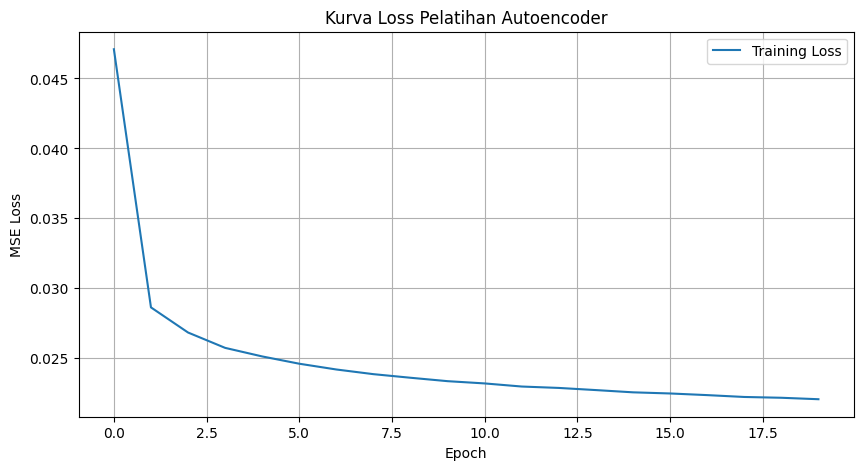


--- Menampilkan Hasil Rekonstruksi ---


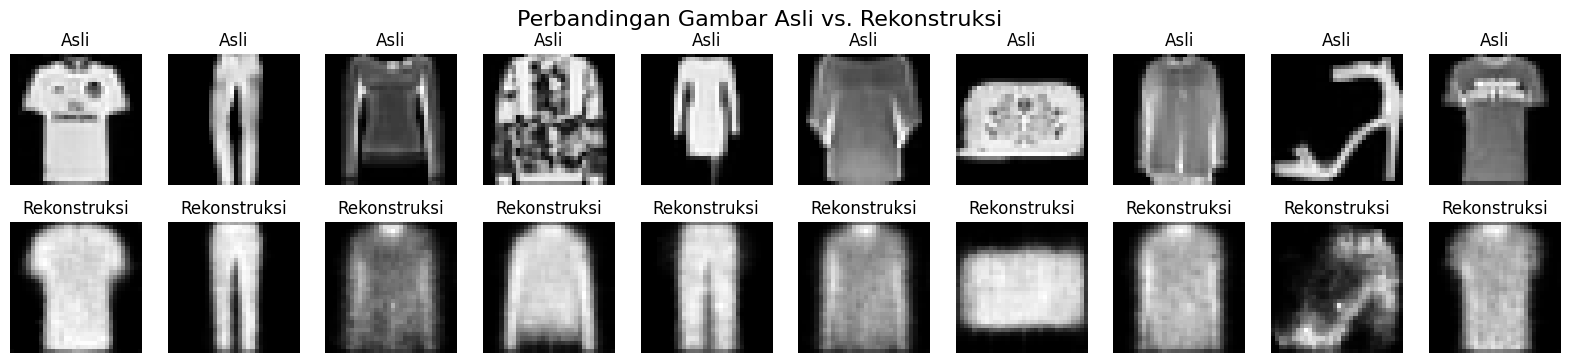


--- Memvisualisasikan Ruang Laten ---


Mengekstrak Ruang Laten: 100%|██████████| 79/79 [00:01<00:00, 41.10it/s]


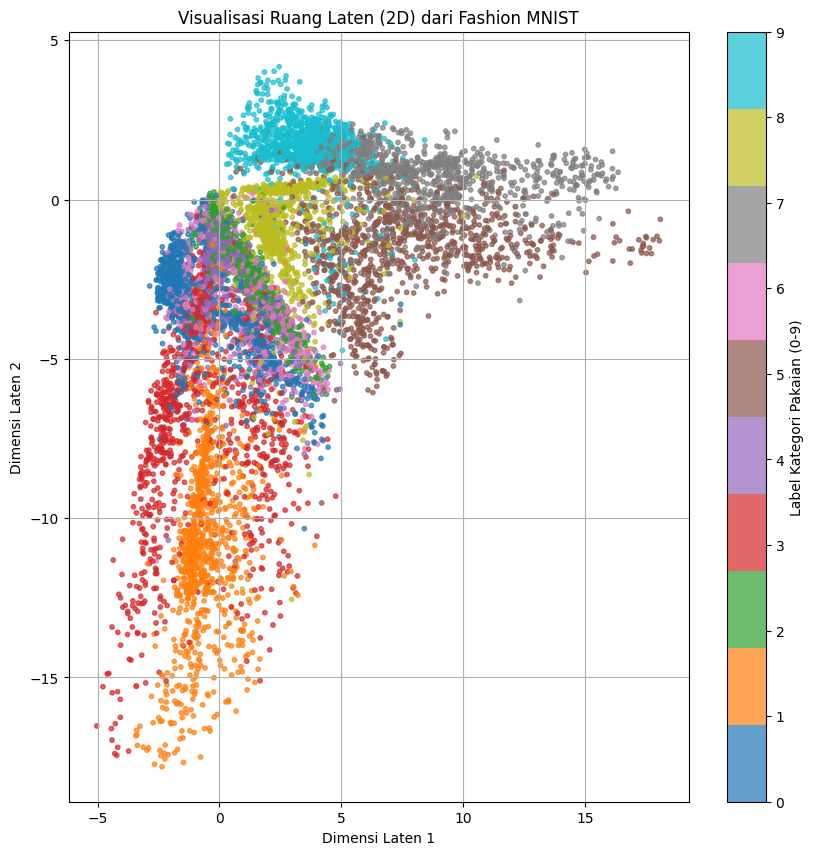

In [19]:
# a. Visualisasi Kurva Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.title('Kurva Loss Pelatihan Autoencoder')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# b. Visualisasi Hasil Rekonstruksi
print("\n--- Menampilkan Hasil Rekonstruksi ---")
model.eval()
with torch.no_grad():
    # Ambil satu batch dari data uji
    test_imgs, _ = next(iter(test_loader))
    test_imgs = test_imgs.to(device)

    # Dapatkan hasil rekonstruksi
    reconstructions = model(test_imgs)

    # Tampilkan 10 gambar asli dan rekonstruksinya
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_imgs[i].cpu().squeeze(), cmap='gray')
        ax.set_title("Asli")
        ax.axis("off")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
        ax.set_title("Rekonstruksi")
        ax.axis("off")
    plt.suptitle("Perbandingan Gambar Asli vs. Rekonstruksi", fontsize=16)
    plt.show()

# c. Visualisasi Ruang Laten (Latent Space)
print("\n--- Memvisualisasikan Ruang Laten ---")
all_embeddings, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Mengekstrak Ruang Laten"):
        imgs = imgs.to(device)
        # Dapatkan representasi laten dari encoder
        z = model.encoder(imgs)
        all_embeddings.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

embeddings = np.vstack(all_embeddings)
labels = np.concatenate(all_labels)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='tab10', alpha=0.7, s=10)
plt.colorbar(scatter, label='Label Kategori Pakaian (0-9)')
plt.title("Visualisasi Ruang Laten (2D) dari Fashion MNIST")
plt.xlabel("Dimensi Laten 1")
plt.ylabel("Dimensi Laten 2")
plt.grid(True)
plt.show()